# EDA con las preguntas restantes

Ya con el dataset limpio y depurado, podemos comenzar a realizar análisis exploratorio para extraer información a partir de los registros y las preguntas.

Con el dataset depurado vamos a intentar responder a las siguientes preguntas, utiliza gráficos para ilustrar tus respuestas:

1. **Distribución de las preguntas por:**
    1. Tema
    2. Entidad
    3. Género
    4. Grupos vulnerables
    5. Grupos de edad (13-18, 18-25, 25-40 y mayores)


In [255]:
import pandas as pd

limpio_df = pd.read_csv('./out_datasets/3-1_base_limpia.csv')

# Distribution of questions by theme
theme_counts = limpio_df['tema'].value_counts()
print("Distribution of questions by theme:")
print(theme_counts)

# Distribution of questions by entity
entity_counts = limpio_df['entidad'].value_counts()
print("Distribution of questions by entity:")
print(entity_counts)

# Distribution of questions by gender
gender_counts = limpio_df['genero'].value_counts()
print("Distribution of questions by gender:")
print(gender_counts)

# Distribution of questions by vulnerable groups
vulnerable_counts = limpio_df['grupo_discriminacion'].value_counts()
print("Distribution of questions by vulnerable groups:")
print(vulnerable_counts)

# Distribution of questions by age groups
age_counts = limpio_df['edad'].value_counts()
print("Distribution of questions by age groups:")
print(age_counts)


Distribution of questions by theme:
tema
Educación                                 4585
Salud                                     3685
No discriminación y grupos vulnerables    2294
Transparencia                             2003
Violencia en contra de las mujeres        1677
Combate a la corrupción                   1183
Name: count, dtype: int64
Distribution of questions by entity:
entidad
Ciudad de México       3951
México                 2256
Jalisco                 991
Veracruz                832
Guanajuato              620
Puebla                  618
Nuevo León              490
Michoacán               429
Querétaro               392
Baja California         365
Chihuahua               333
Chiapas                 315
Hidalgo                 313
Morelos                 292
Yucatán                 292
Oaxaca                  278
Tabasco                 266
Coahuila                248
Guerrero                240
San Luis Potosí         233
Tamaulipas              221
Sonora            

2. **Cruces entre las variables del punto anterior:**
    1. Qué temas interesan más por género
    2. Por entidad
    3. Por grupo de edad


In [6]:
tema_genero = limpio_df.groupby(['tema', 'genero']).size()
print(tema_genero)

tema_entidad = limpio_df.groupby(['tema', 'entidad']).size()
print(tema_entidad)

tema_edad = limpio_df.groupby(['tema', 'edad']).size()
print(tema_edad)

tema                                    genero    
Combate a la corrupción                 Femenino       309
                                        Masculino      855
                                        Otro             9
                                        Selecciona      10
Educación                               Femenino      1586
                                        Masculino     2919
                                        Otro            46
                                        Selecciona      34
No discriminación y grupos vulnerables  Femenino       892
                                        Masculino     1289
                                        Otro            90
                                        Selecciona      23
Salud                                   Femenino      1384
                                        Masculino     2172
                                        Otro            32
                                        Selecciona      97
Trans


3. **Separa las preguntas por tema y genera nubes de palabras y tablas de frecuencia para mostrar:**
    1. Qué palabras, bi-gramas o tri-gramas son los que más se repiten por tema
    2. Por entidad
    3. Por género


Importamos las herramientas necesarias

In [256]:
from sklearn.feature_extraction.text import CountVectorizer
from unidecode import unidecode
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
import re

stop_words = nltk.corpus.stopwords.words('spanish')
stop_words.append('mexico')
stop_words.append('ser') # Al parcer esta palabra se repite mucho
stop_words.append('of') # Dado que no se limpian las referencias, bibiliografias, etc, se agregan unas palabras en ingles
stop_words.append('corruption') 

nlp = spacy.load('es_core_news_md')

Se define nuevamente nuestras funciones de preprocesamiento

In [257]:
def lemmatizer(text: str) -> str:
    doc = nlp(text)
    return " ".join([word.lemma_ for word in doc])

def normalize_text(texto: str) -> str:
    #1. Quitamos el '¿'
    texto = texto.replace('¿', '')
    texto = texto.replace('@', 'o')

    #2. Removemos acentos
    texto = unidecode(texto)

    #3. Remover todo caracter no alfanumerico, lowercase, sin saltos de linea.
    texto = re.sub(r"[^a-zA-Z0-9\s]", '', texto, re.I|re.A).lower().strip()

    texto = lemmatizer(texto)

    #4. Tokenize document
    tokens = nltk.word_tokenize(texto)

    #5. filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]

    #6. re-create document from filtered tokens
    return ' '.join(filtered_tokens)

Se normaliza/limpia el texto

In [258]:
limpio_df['norm_text'] = limpio_df['pregunta'].apply(normalize_text)

### Por tema
Se consiguen los temas del debate

In [259]:
temas = list(set(limpio_df['tema']))
temas.sort()
temas

['Combate a la corrupción',
 'Educación',
 'No discriminación y grupos vulnerables',
 'Salud',
 'Transparencia',
 'Violencia en contra de las mujeres']

#### Nube de palabras

Se genera la nube de palabras

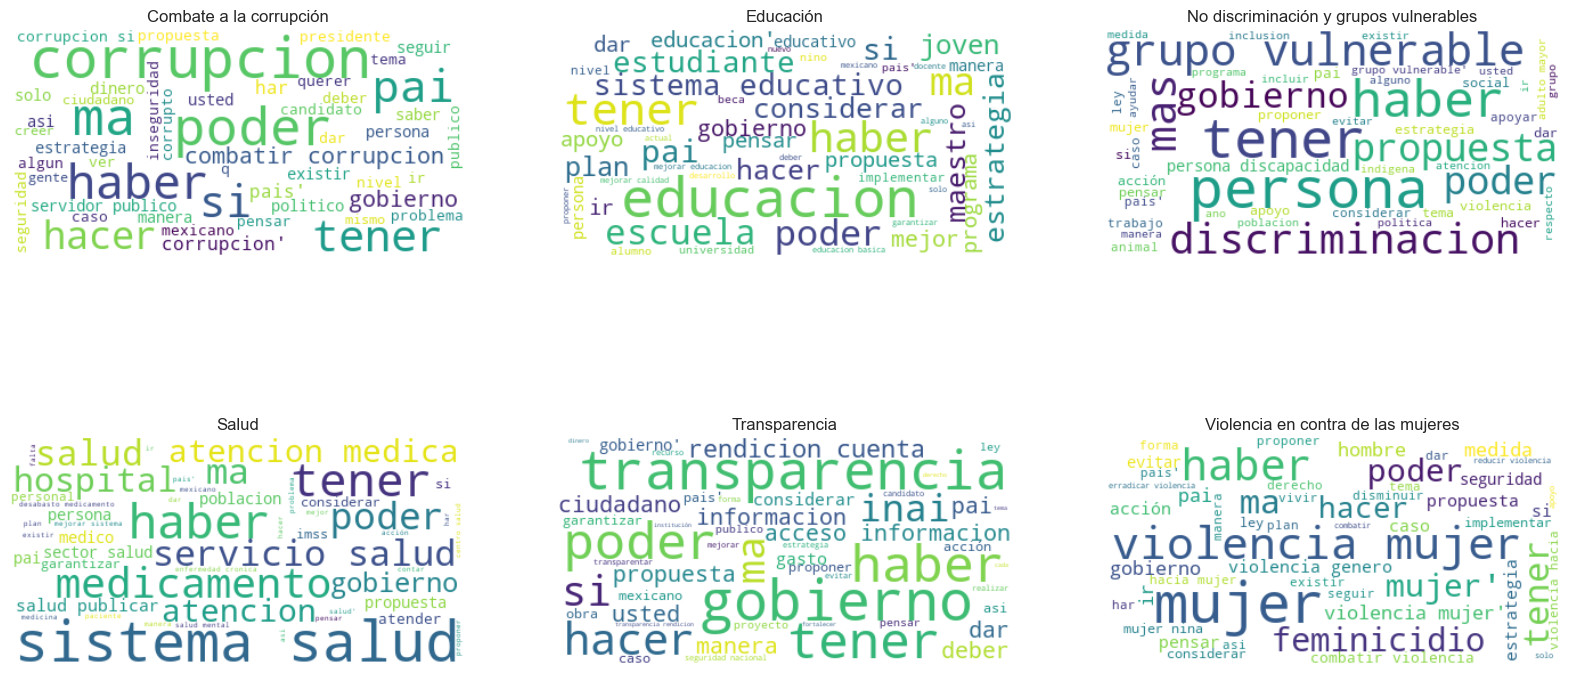

In [260]:
wc = WordCloud(background_color="white", stopwords=stop_words,
               max_words=50, max_font_size=50, random_state=42)
plt.rcParams['figure.figsize'] = [20, 15]

n = len(temas)
for i, tema in enumerate(temas):
    df = limpio_df[limpio_df['tema'] == tema]
    wc.generate(text=str(list(df['norm_text'])))
    plt.subplot(n // 2, n // 2, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(tema)
plt.show()

Generalizamos los pasos previos y probamos

In [261]:
def wc_generator_by(key: str):
    items = list(set(limpio_df[key]))
    items.sort()
    n = len(items)
    for i, item in enumerate(items):
        df = limpio_df[limpio_df[key] == item]
        wc.generate(text=str(list(df['norm_text'])))
        plt.subplot(n // 2, 3, i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(item)
    plt.show()

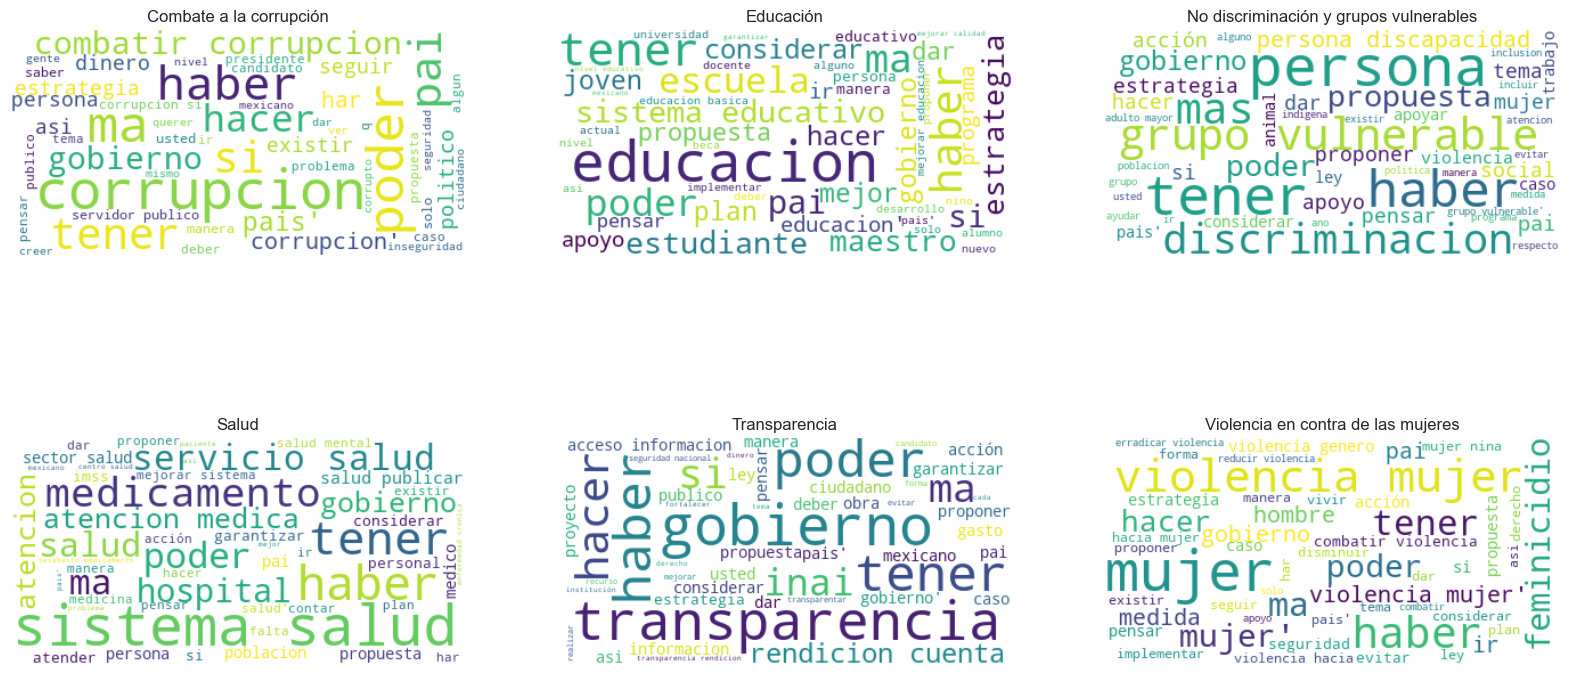

In [262]:
wc_generator_by('tema')

#### N-gramas

In [263]:
corpus = list(limpio_df[limpio_df['tema'] == 'Salud']['norm_text'])
cv = CountVectorizer().fit(corpus)
bag_of_words = cv.transform(corpus)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in
                cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda words: words[1], reverse=True)
words_freq[:10]


[('salud', 2633),
 ('medicamento', 781),
 ('sistema', 774),
 ('tener', 750),
 ('atencion', 662),
 ('servicio', 598),
 ('mejorar', 560),
 ('haber', 513),
 ('estrategia', 448),
 ('persona', 440)]

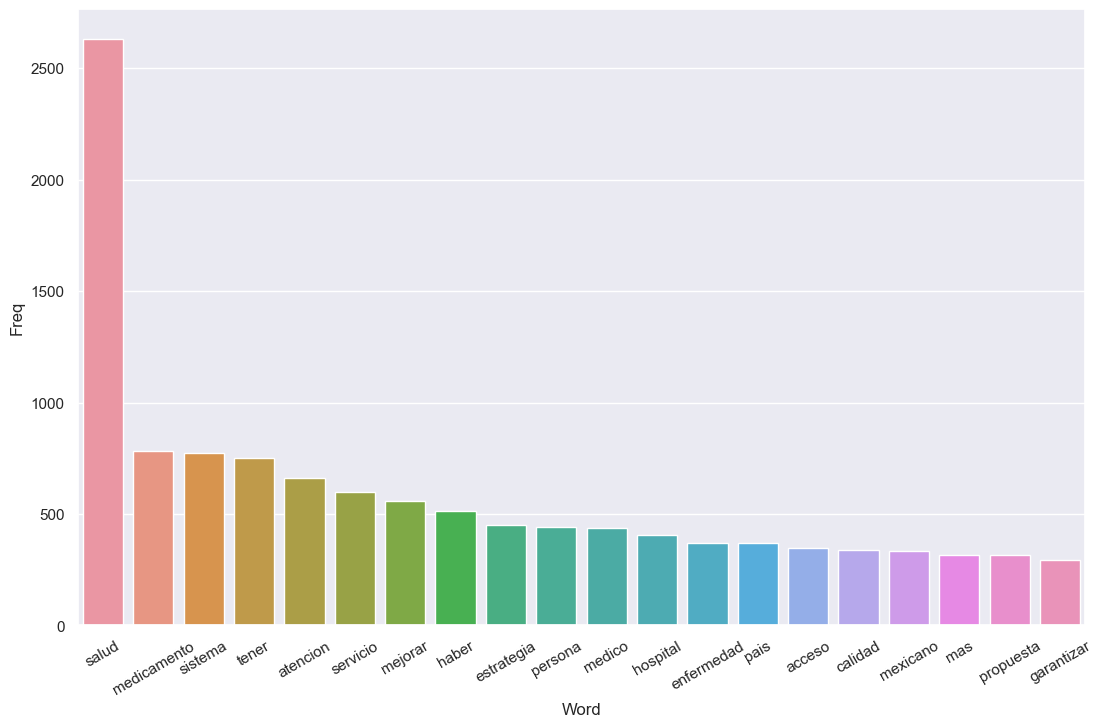

In [264]:
top_words = words_freq[:20]
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
sns.set_theme(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

Ploteamos los 6 temas en una sola figura

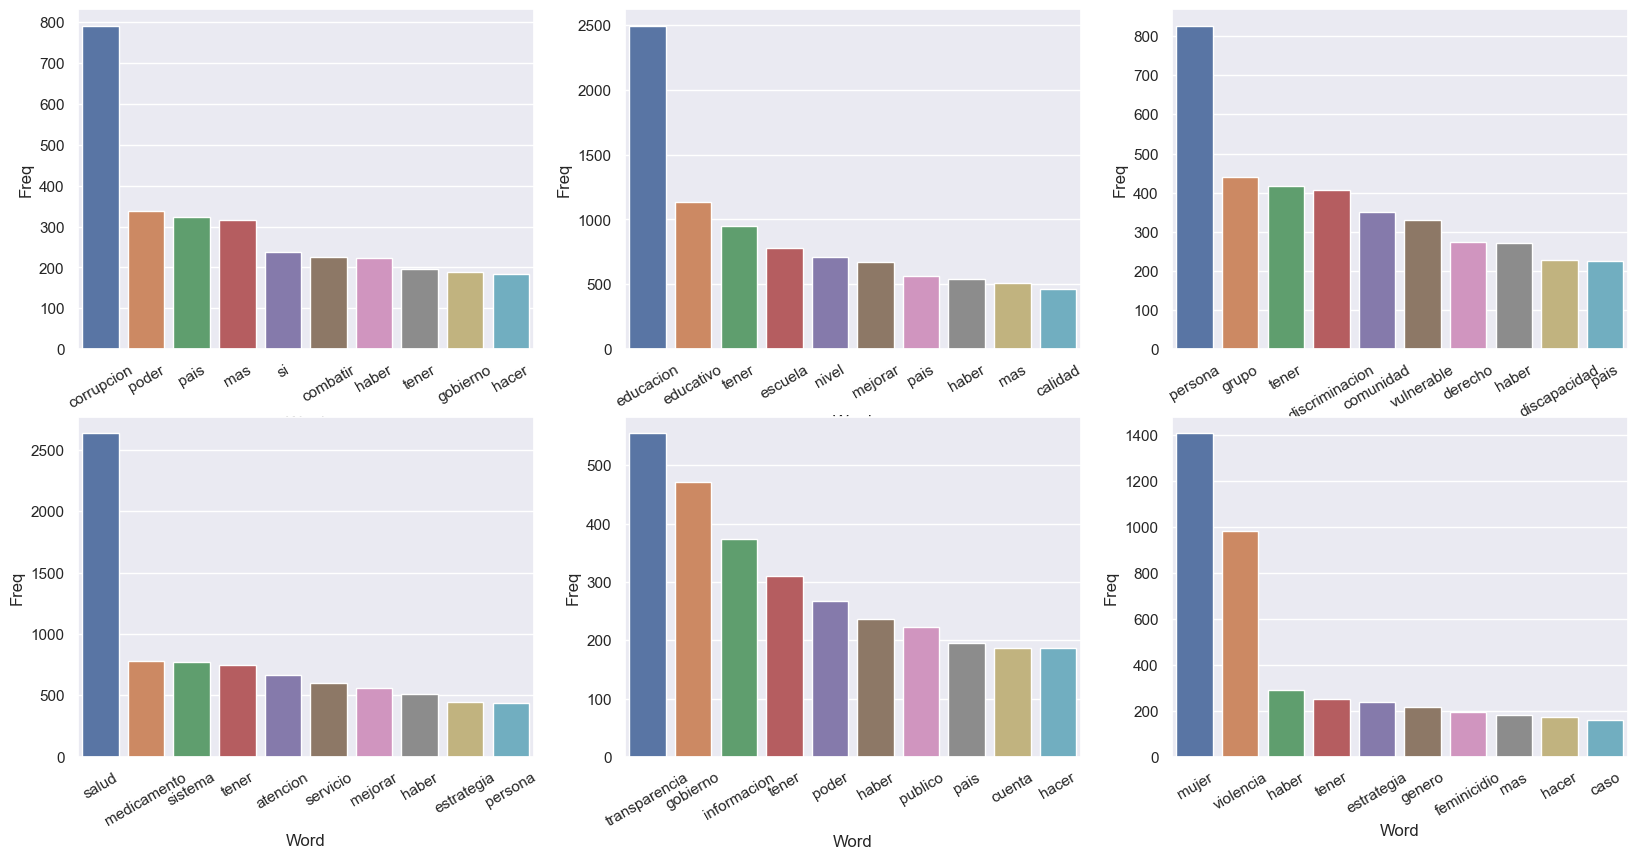

In [265]:
for i, tema in enumerate(temas):
    corpus = list(limpio_df[limpio_df['tema'] == tema]['norm_text'])
    cv = CountVectorizer().fit(corpus)
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                    cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda words: words[1], reverse=True)
    top_words = words_freq[:10]
    top_df = pd.DataFrame(top_words)
    top_df.columns=["Word", "Freq"]
    #Barplot of most freq words
    sns.set_theme(rc={'figure.figsize':(20,15)})
    ax = plt.subplot(3, 3, i+1)
    g = sns.barplot(x="Word", y="Freq", data=top_df)
    g.set_xticklabels(g.get_xticklabels(), rotation=30);

Generalizamos y aislamos cada proceso en su propia funcion

In [266]:
def get_top_n_words(corpus, n, **kwargs):
    cv = CountVectorizer(**kwargs).fit(corpus)
    bag_of_words = cv.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in
                  cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda word: word[1], reverse=True)
    return words_freq[:n]

In [284]:
def plot_n_grams(key, n_grams, **kwargs):
    items = list(set(limpio_df[key]))
    items.sort()
    n = len(items) if len(items) != 3 else 4
    for i, item in enumerate(items):
        df = limpio_df[limpio_df[key] == item]
        corpus = list(df['norm_text'])
        top_words = get_top_n_words(corpus, n_grams, **kwargs)
        top_df = pd.DataFrame(top_words)
        top_df.columns=["Word", "Freq"]
        #Barplot of most freq words
        sns.set_theme(rc={'figure.figsize':(20,15)})
        ax = plt.subplot(n // 2, 2, i+1)
        g = sns.barplot(y="Word", x="Freq", data=top_df, orient='h')
        ax.set_title(item, color='green', fontsize=16)

Se prueba con 1-grama

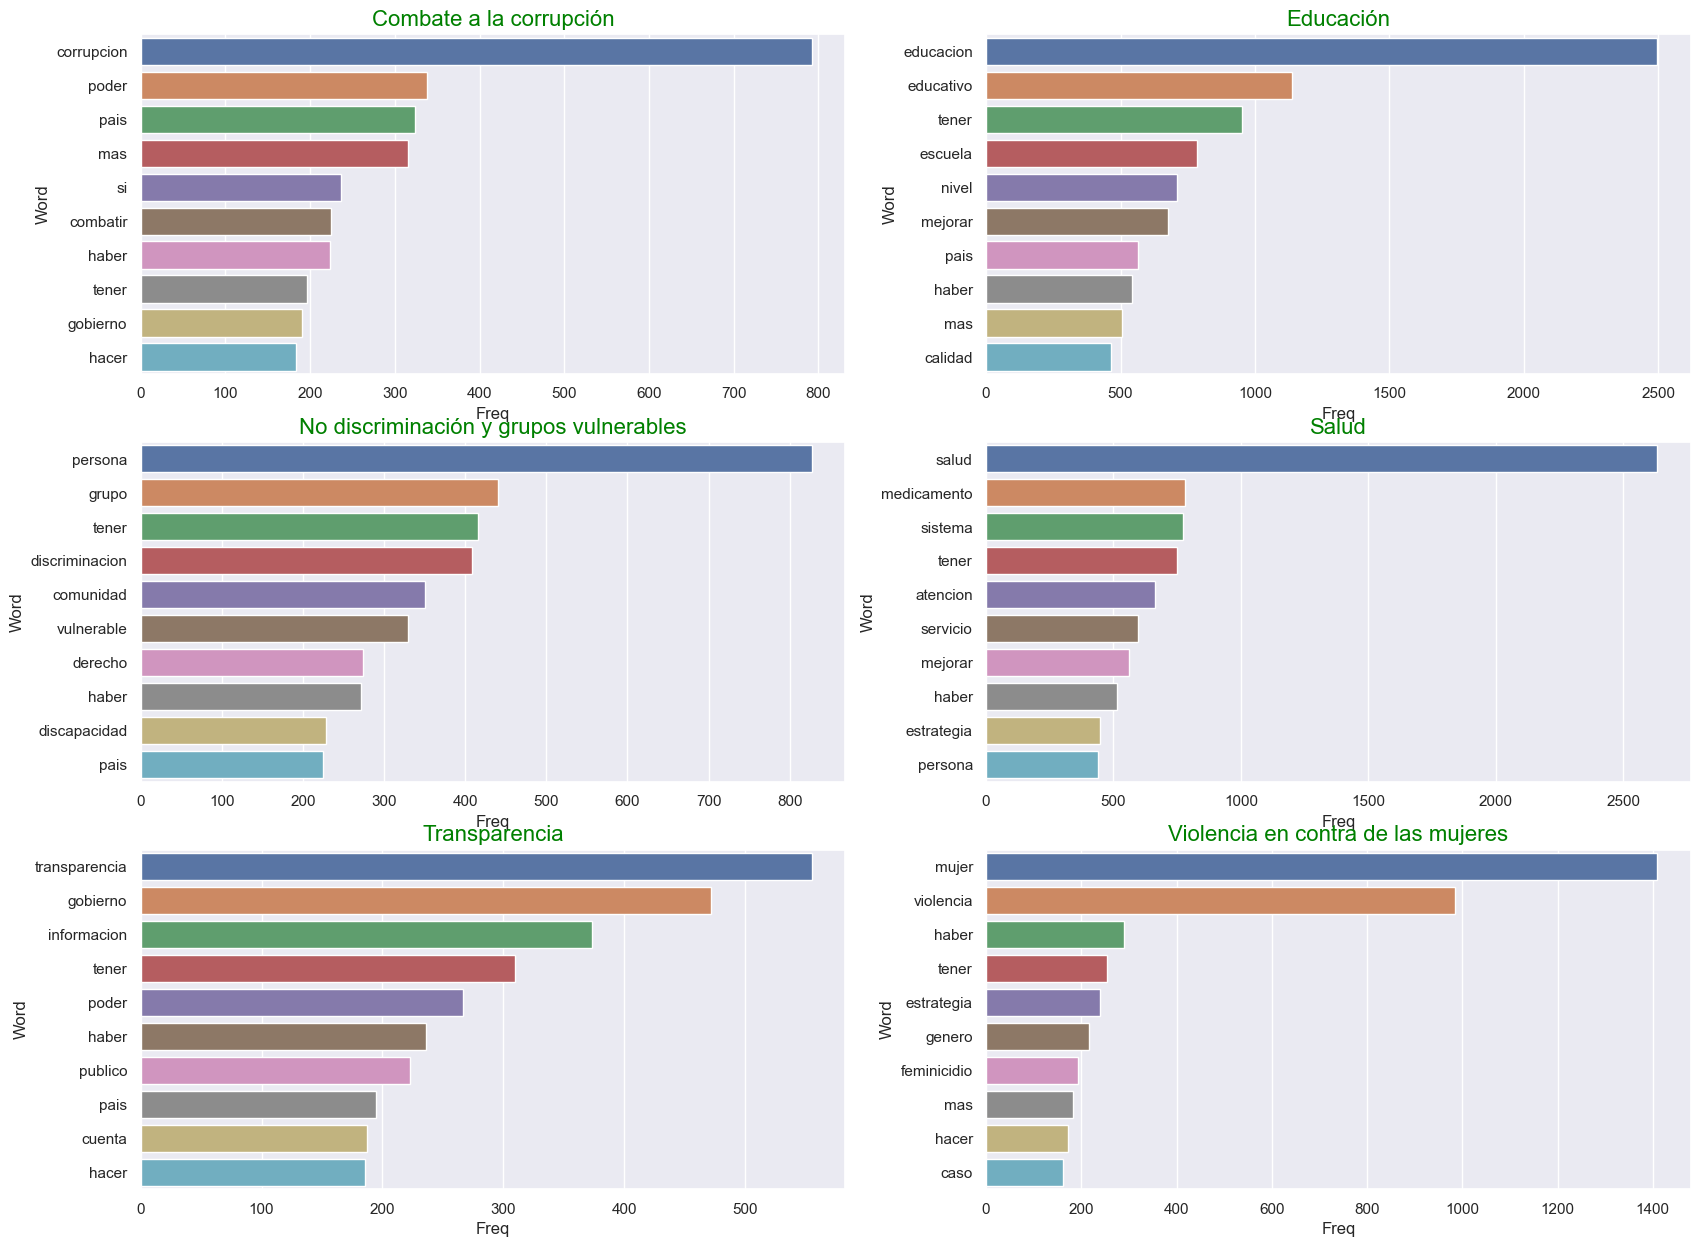

In [268]:
plot_n_grams('tema', 10)

##### Bi-gramas

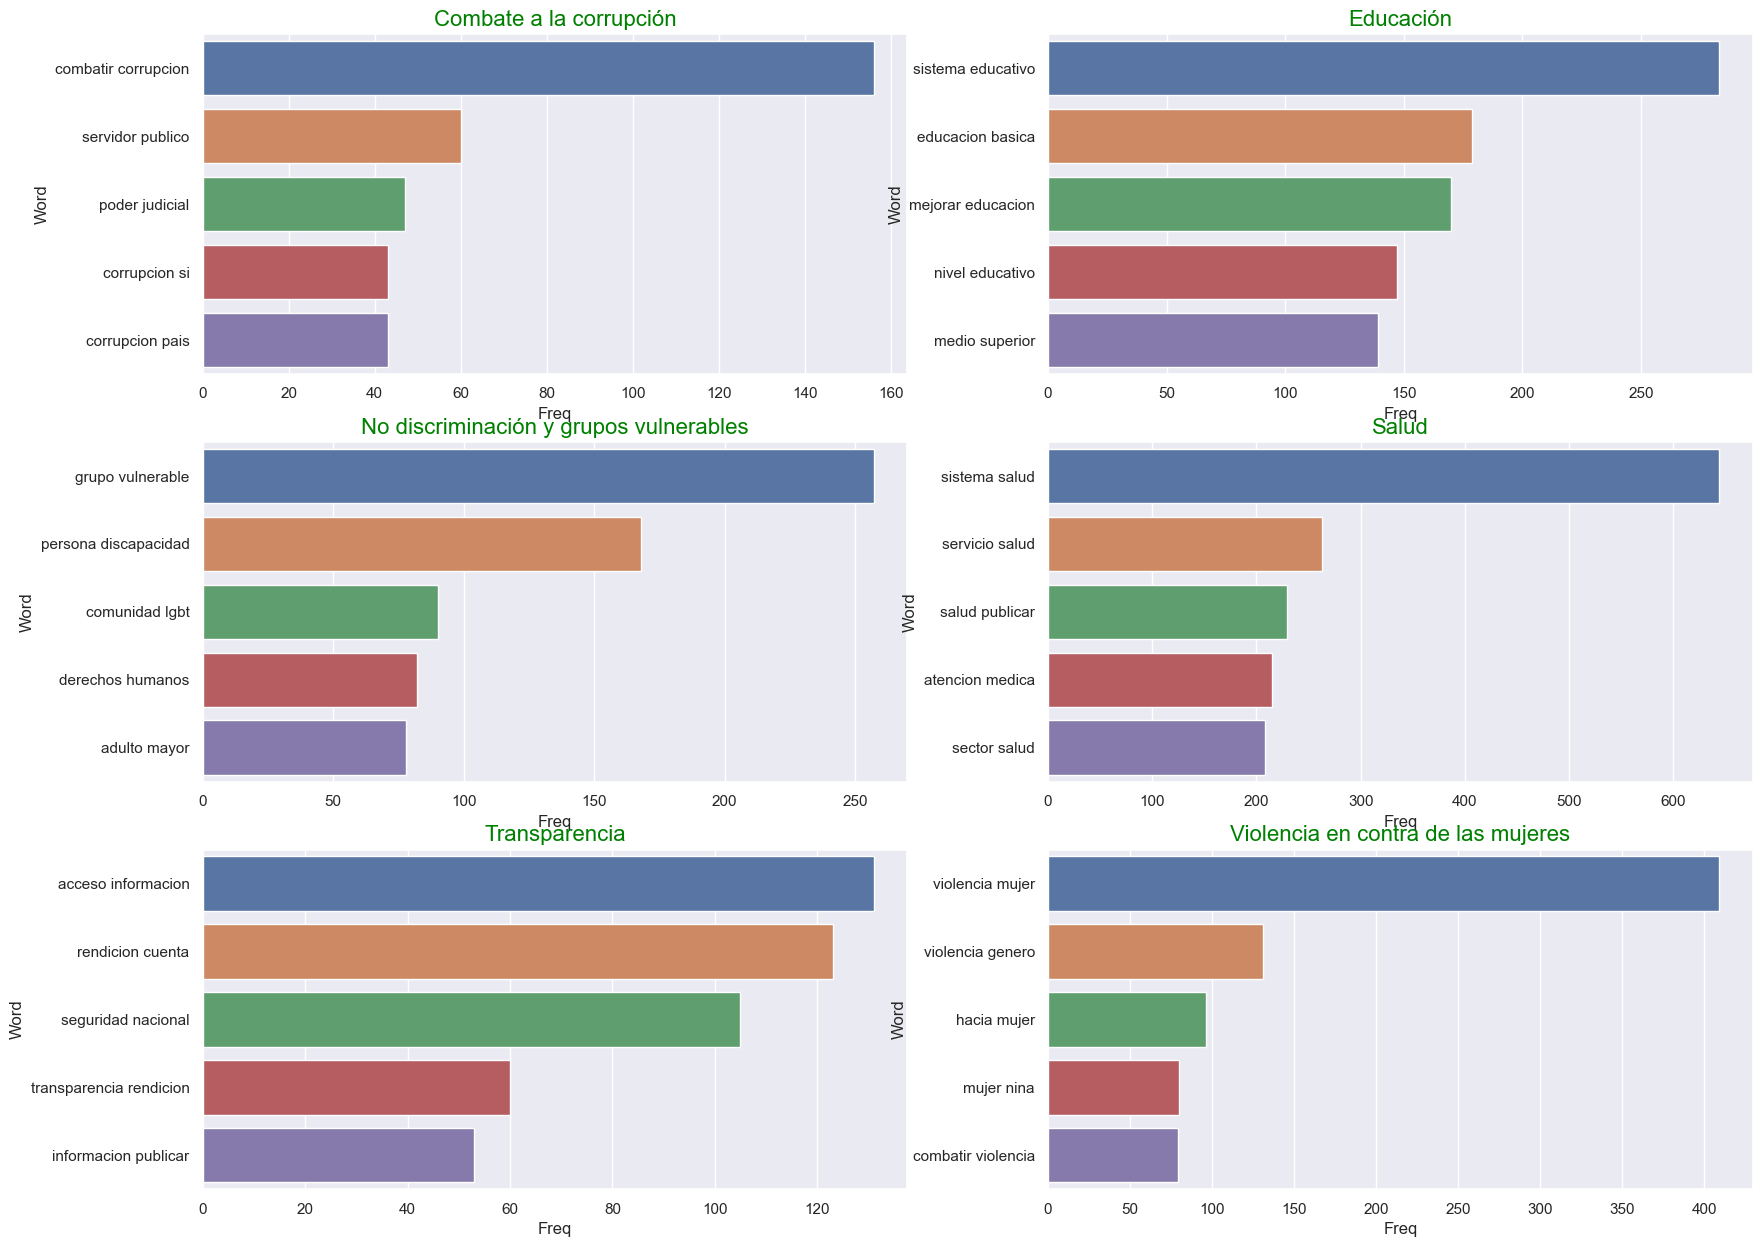

In [269]:
plot_n_grams('tema', 5, ngram_range=(2,2))

##### Tri-gramas

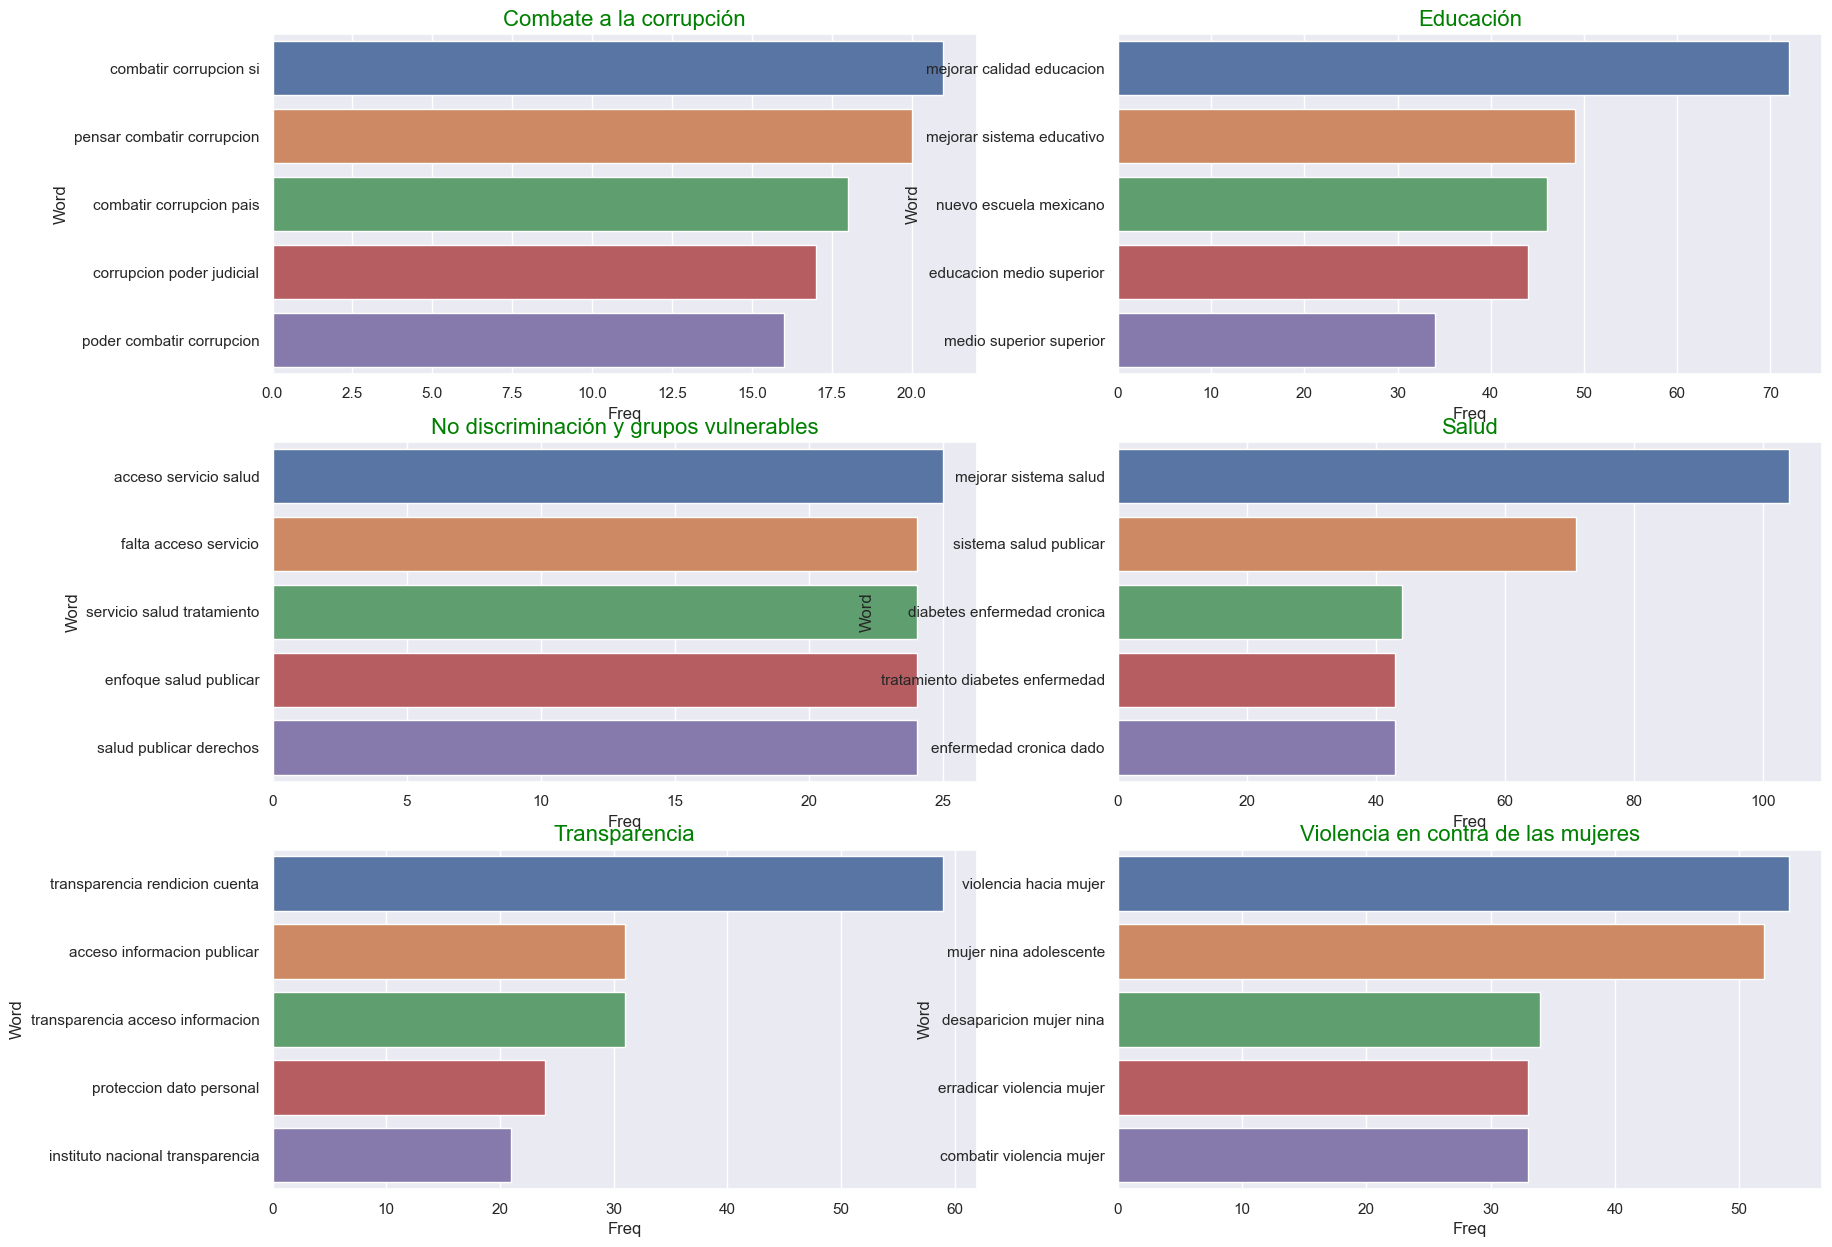

In [270]:
plot_n_grams('tema', 5, ngram_range=(3,3))

### Por entidad
#### Nube de palabaras

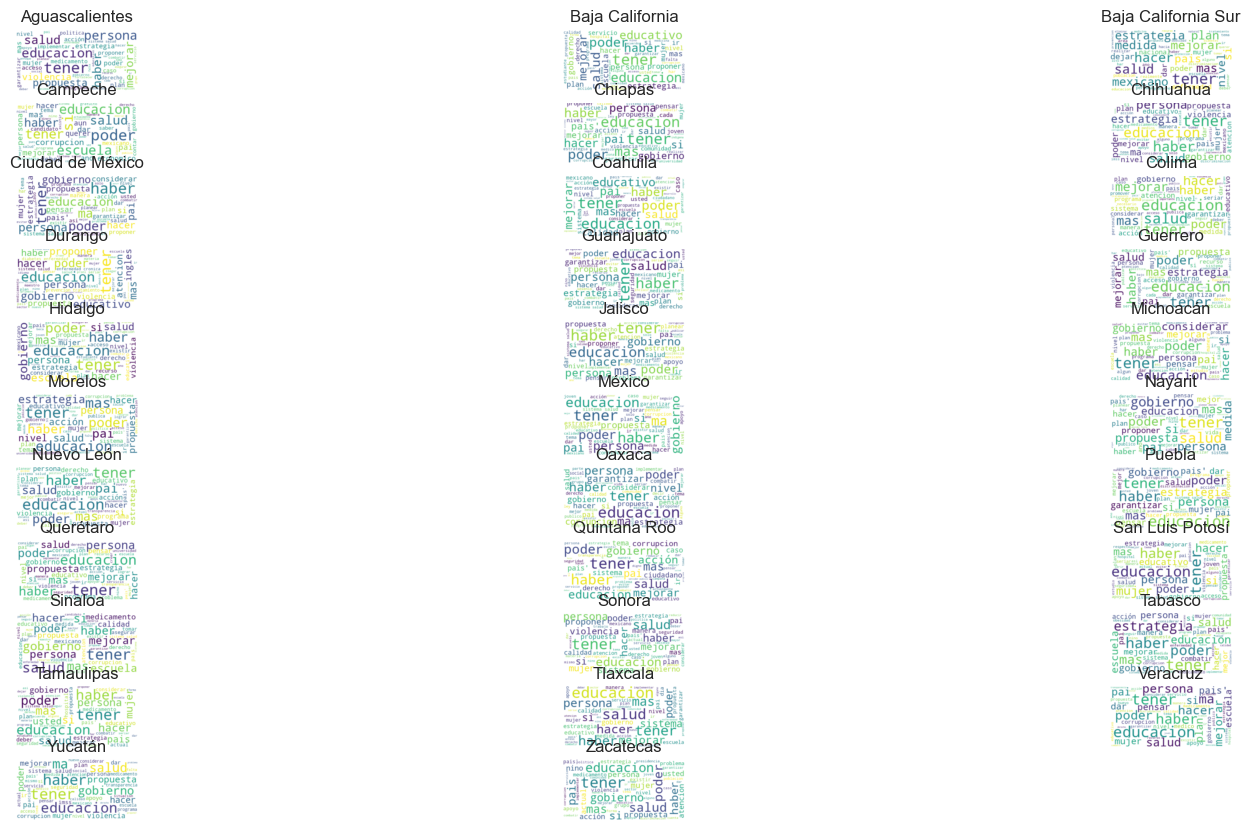

In [271]:
wc_generator_by('entidad')

#### Bi-gramas

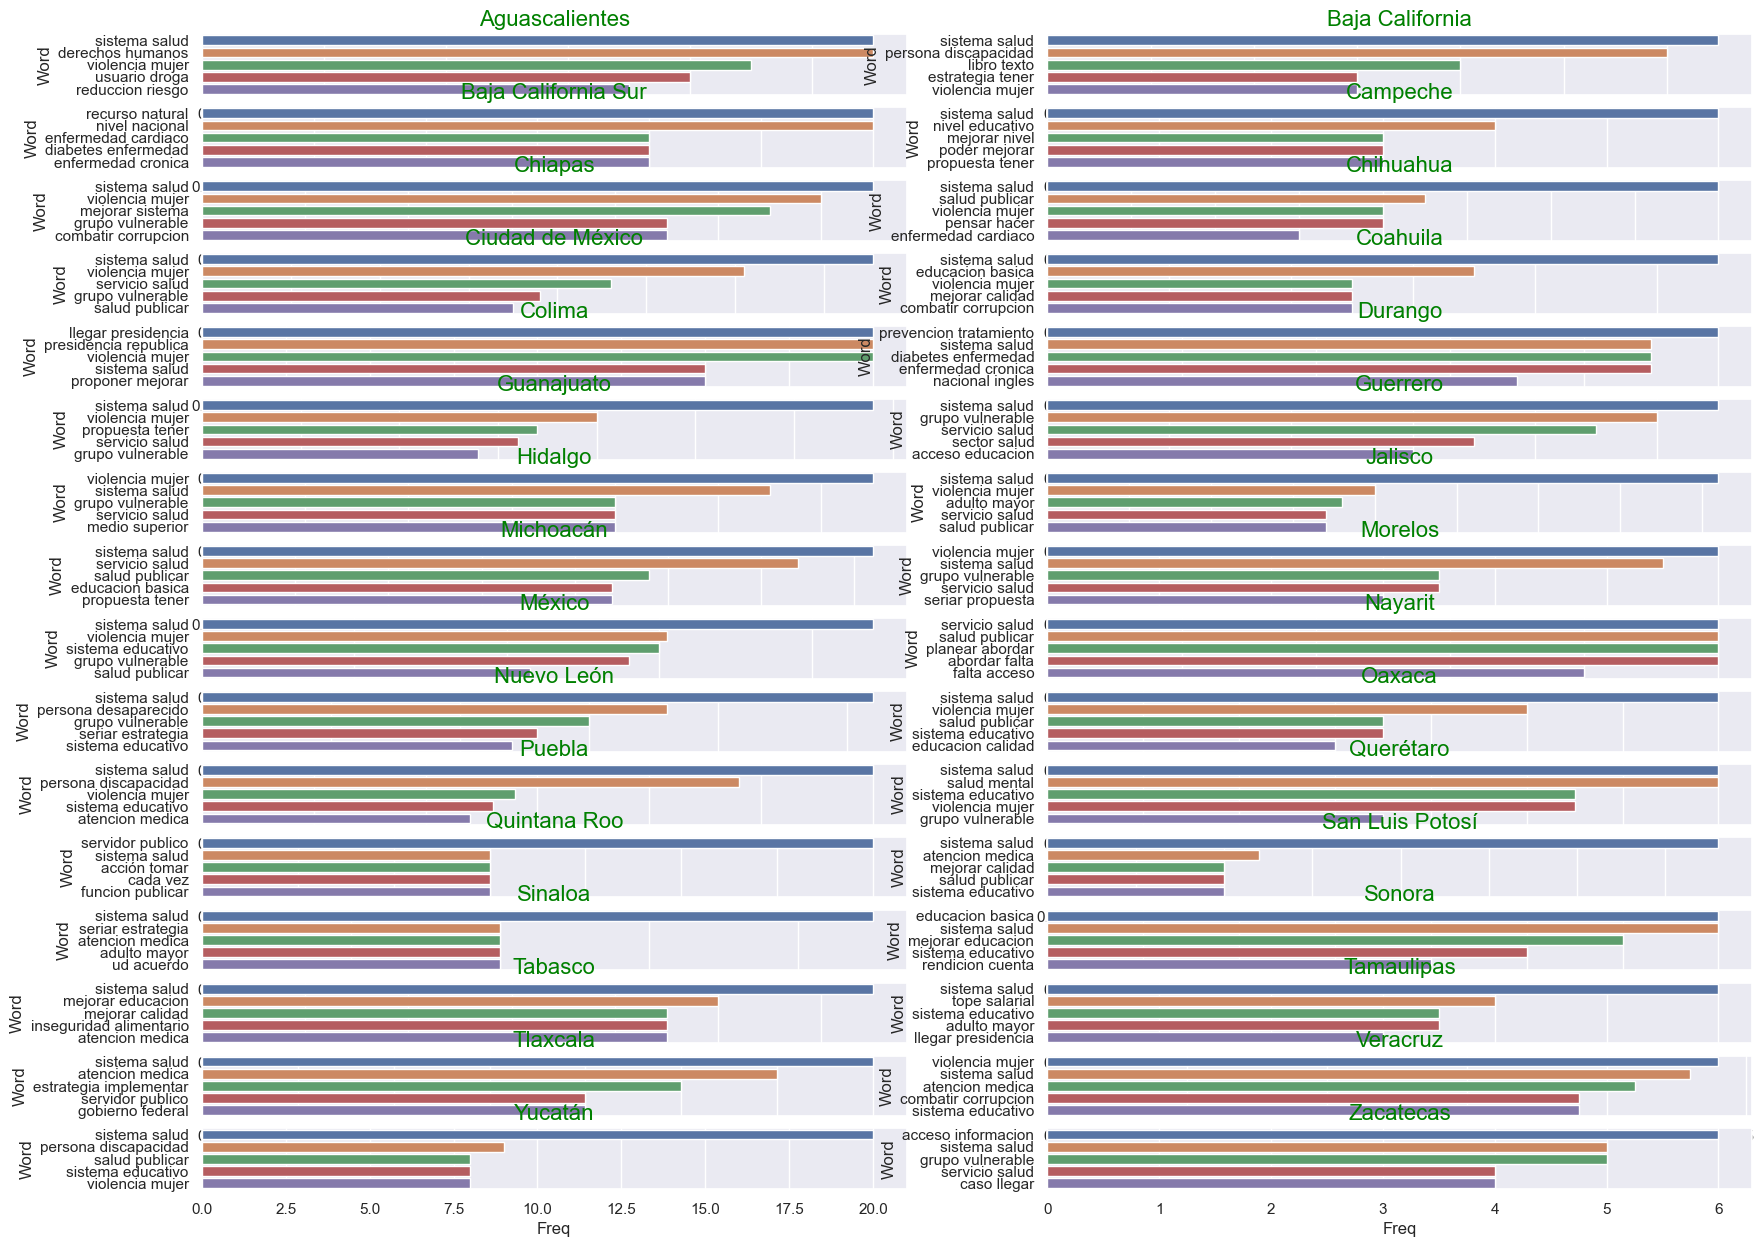

In [272]:
plot_n_grams('entidad',5, ngram_range=(2,2))

### Tri-gramas

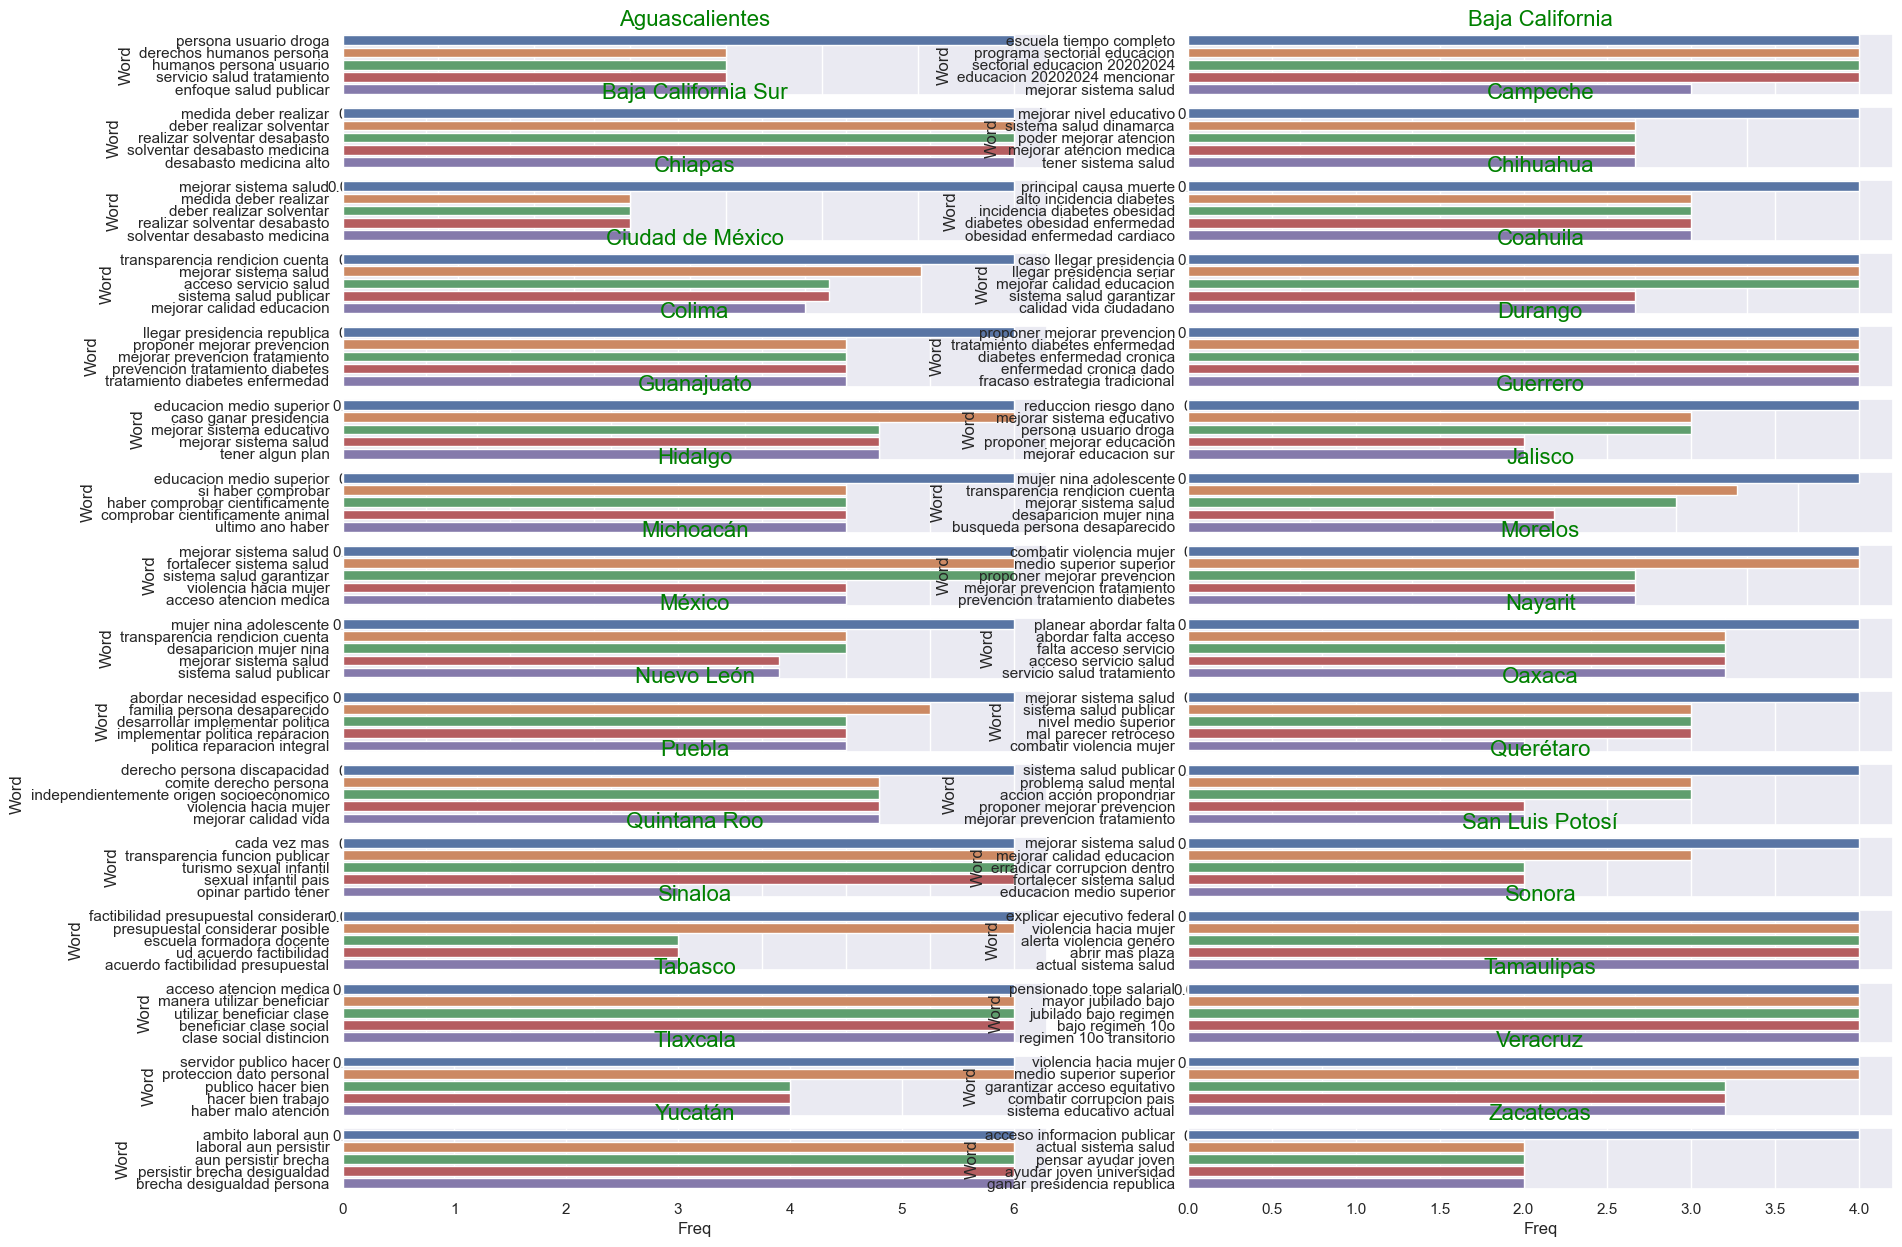

In [273]:
plot_n_grams('entidad', 5, ngram_range=(3,3))

### Por genero
#### Nube de palabras

Al parecer hay basura en el genero

In [276]:
limpio_df['genero'] = limpio_df['genero'].apply(lambda s: s if s != 'Selecciona' else 'Otro')

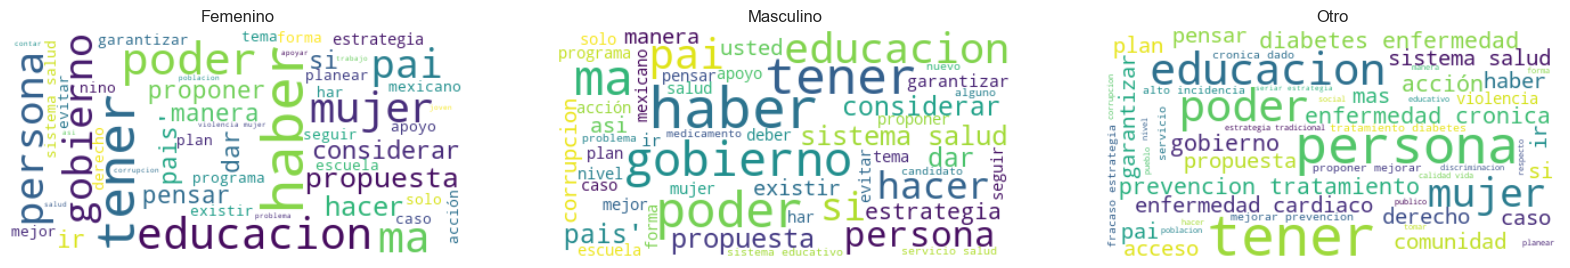

In [277]:
wc_generator_by('genero')


4. **Separa las preguntas por tema y realiza un análisis de sentimientos y de emociones.**
    1. Muestra los resultados en forma tabular o gráfica

#### Bi-gramas

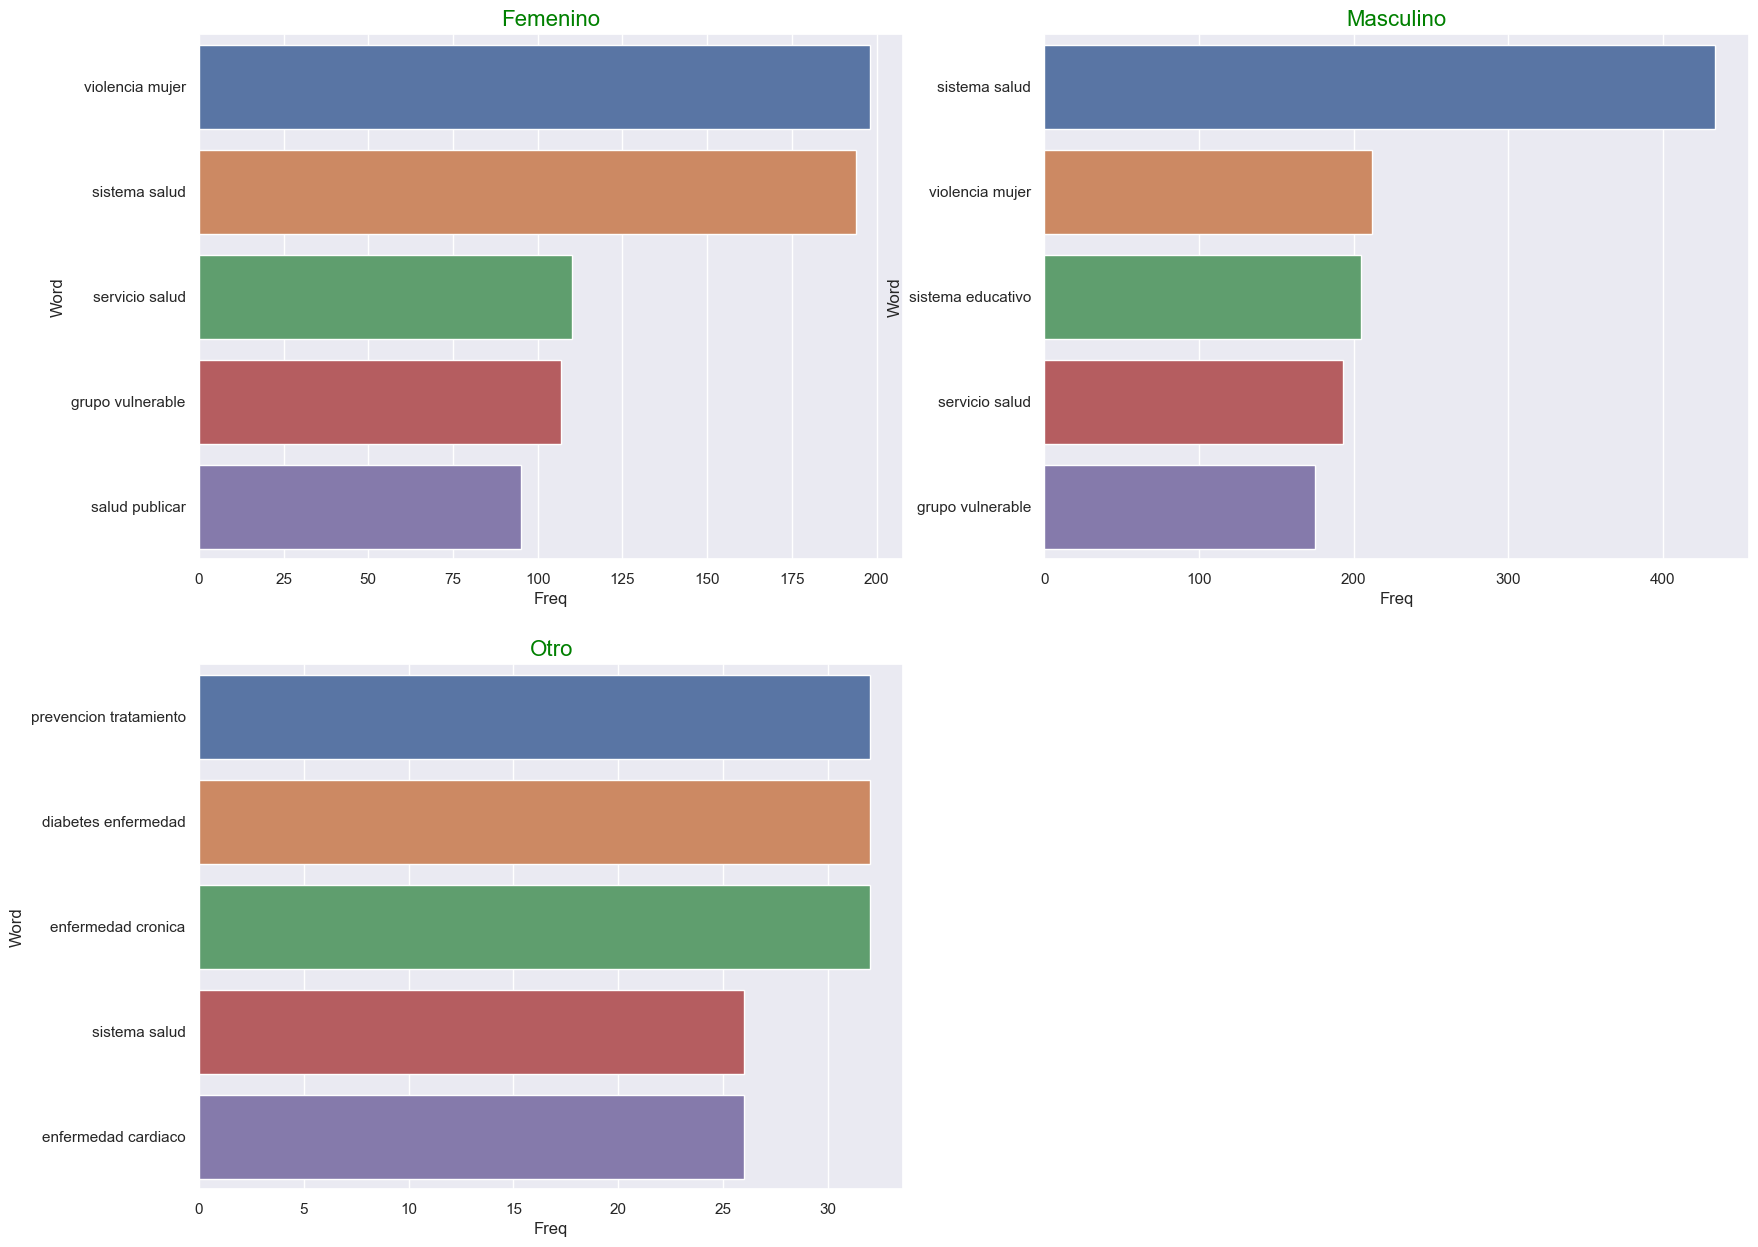

In [285]:
plot_n_grams('genero', 5, ngram_range=(2,2))

#### Tri-gramas

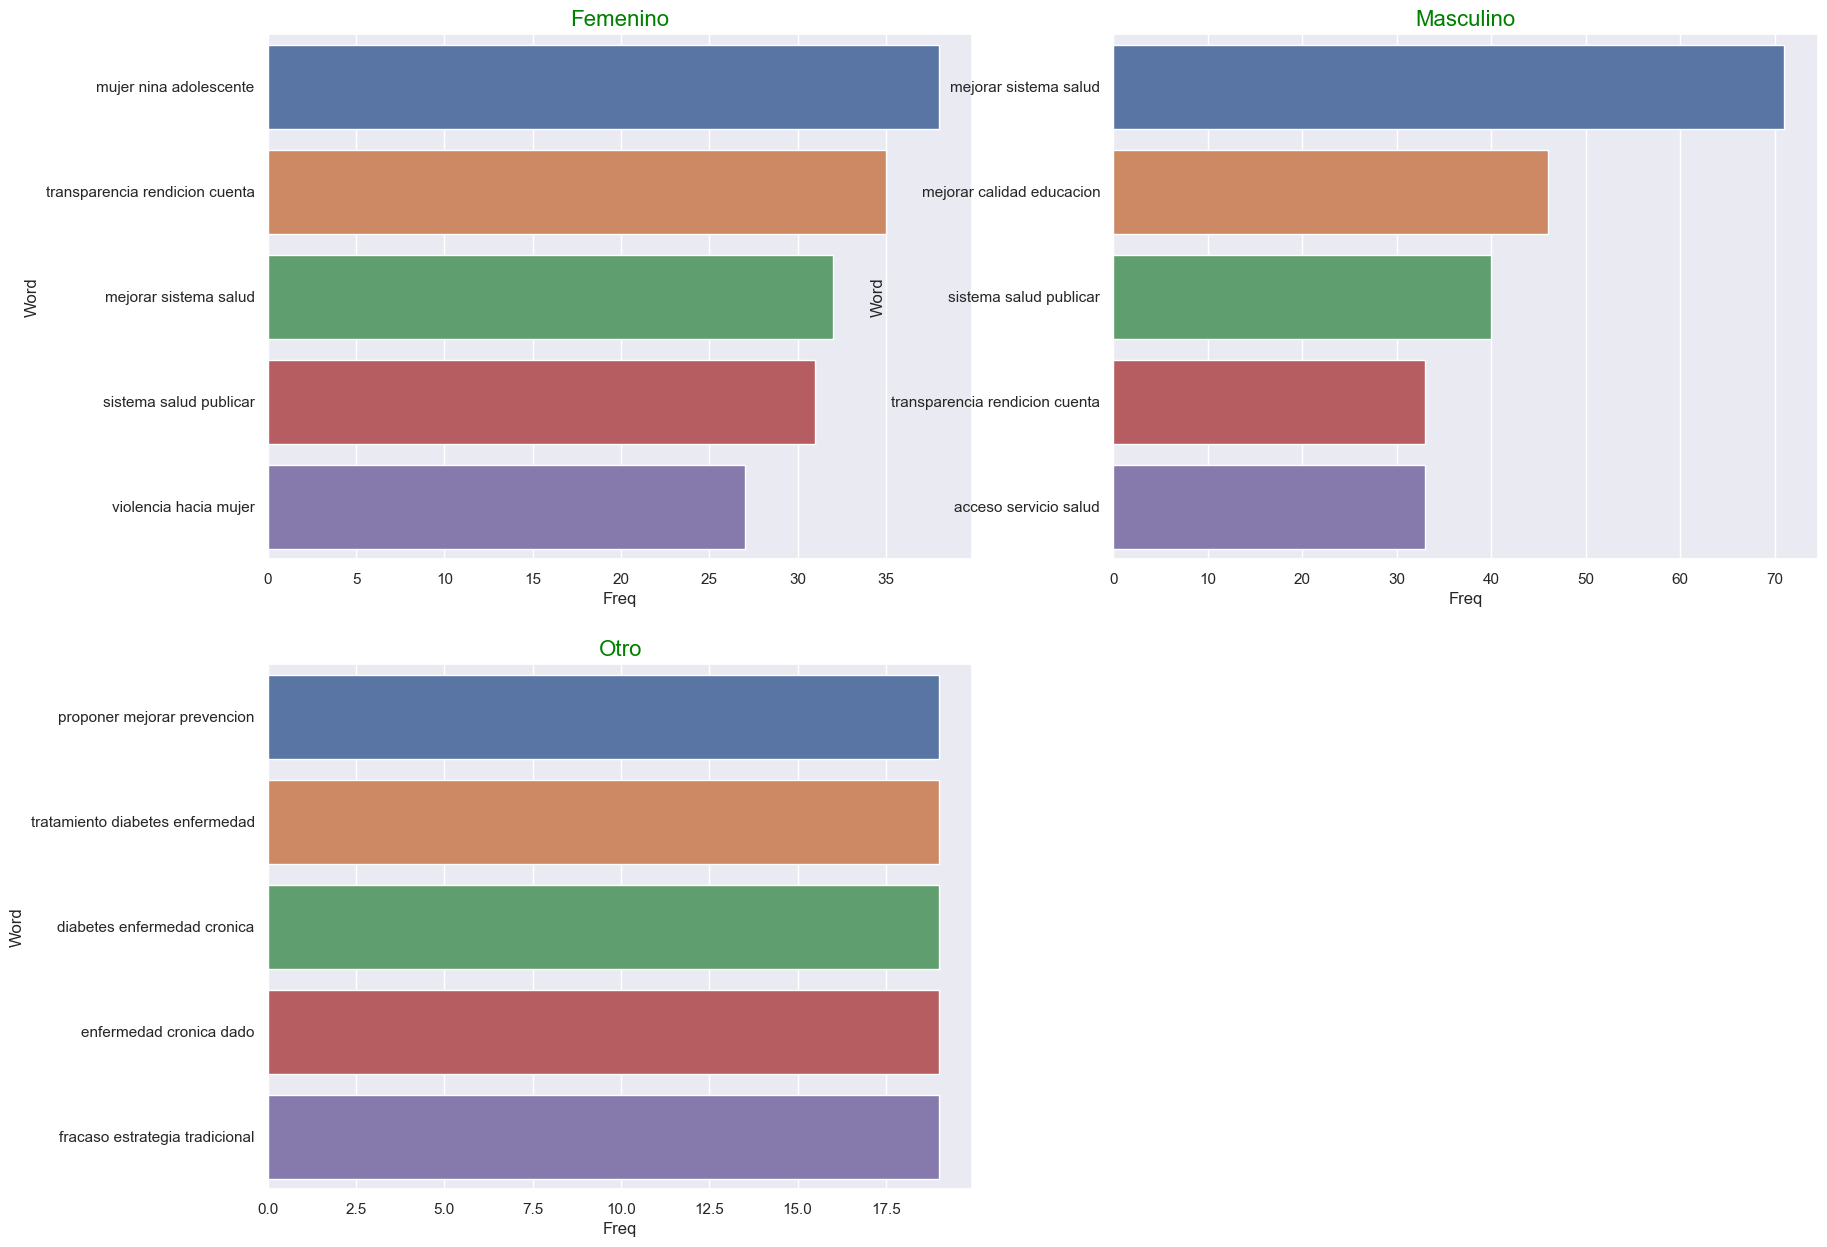

In [286]:
plot_n_grams('genero', 5, ngram_range=(3,3))